## **SKIN LESION DIAGNOSIS**

In [ ]:
# import system libs
import os
import time
import shutil
import itertools

# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras import regularizers
from tensorflow.keras.metrics import categorical_crossentropy

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')


modules loaded


## Read data

In [ ]:
# specify paths
meta_data_path = '/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_metadata.csv'
data_folder_path = '../input/skin-cancer-mnist-ham10000'
data_path = '/kaggle/input/skin-cancer-mnist-ham10000/hmnist_28_28_RGB.csv'

In [ ]:
meta_data = pd.read_csv(meta_data_path)
meta_data.head(3)

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp


### Data Info and Description

In [ ]:
print("frequency count of skin lesion categories")
dict(meta_data.dx.value_counts())

frequency count of skin lesion categories


{'nv': 6705,
 'mel': 1113,
 'bkl': 1099,
 'bcc': 514,
 'akiec': 327,
 'vasc': 142,
 'df': 115}

In [ ]:
cancer_data = meta_data
for column in cancer_data.columns:
    missing_count = cancer_data[column].isnull().sum()
    print(f'Number of NaN values in Column ({column}): {missing_count}\n')

Number of NaN values in Column (lesion_id): 0

Number of NaN values in Column (image_id): 0

Number of NaN values in Column (dx): 0

Number of NaN values in Column (dx_type): 0

Number of NaN values in Column (age): 57

Number of NaN values in Column (sex): 0

Number of NaN values in Column (localization): 0



In [ ]:
# Imputing missing values in age column
cancer_data['age'].fillna((cancer_data['age'].mean()), inplace=True)

for column in cancer_data.columns:
    missing_count = cancer_data[column].isnull().sum()
    print(f'Number of NaN values in Column ({column}) after imputing with mean: {missing_count}\n')

Number of NaN values in Column (lesion_id) after imputing with mean: 0

Number of NaN values in Column (image_id) after imputing with mean: 0

Number of NaN values in Column (dx) after imputing with mean: 0

Number of NaN values in Column (dx_type) after imputing with mean: 0

Number of NaN values in Column (age) after imputing with mean: 0

Number of NaN values in Column (sex) after imputing with mean: 0

Number of NaN values in Column (localization) after imputing with mean: 0



In [ ]:
from glob import glob
skin_lesion_type = {
    'df': 'Dermatofibroma',
    'bcc': 'Basal cell carcinoma',
    'mel': 'Melanoma',
    'akiec': 'Actinic keratoses',
    'bkl': 'Benign keratosis-like lesions',
    'nv': 'Melanocytic nevi',
    'vasc': 'Vascular lesions'
}

image_ids_paths = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(data_folder_path, '*', '*.jpg'))}

In [ ]:
cancer_data['img_path'] = cancer_data['image_id'].map(lambda x: image_ids_paths.get(x))
cancer_data['lesion_type'] = cancer_data['dx'].map(lambda x: skin_lesion_type.get(x))
cancer_data['lesion_type_idx'] = pd.Categorical(cancer_data['lesion_type']).codes

cancer_data.head(3)

,lesion_id,image_id,dx,dx_type,age,sex,localization,img_path,lesion_type,lesion_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,../input/skin-cancer-mnist-ham10000/ham10000_i...,Benign keratosis-like lesions,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,../input/skin-cancer-mnist-ham10000/ham10000_i...,Benign keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,../input/skin-cancer-mnist-ham10000/ham10000_i...,Benign keratosis-like lesions,2


## Data Analysis and Visualisation

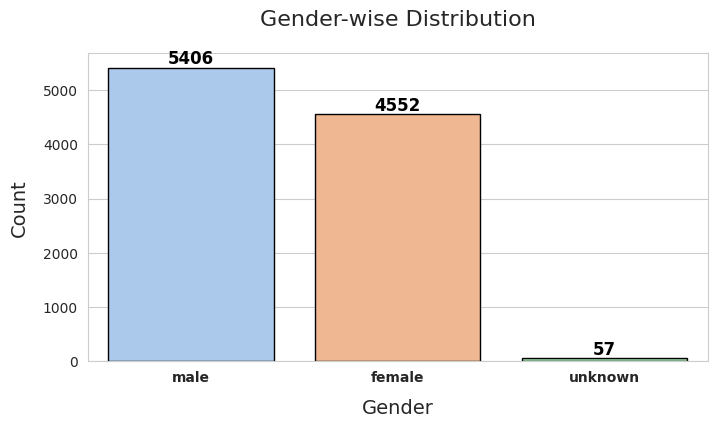

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Gender-wise differentiability with pastel colors
sns.set_style('whitegrid')
pastel_palette = sns.color_palette("pastel")
fig, ax = plt.subplots(figsize=(8,4))

# Use the 'hue' parameter for better visualization if you have another categorical variable
ax = sns.countplot(x='sex', data=cancer_data, palette=pastel_palette, edgecolor='black')

# Add labels to the bars
for container in ax.containers:
    ax.bar_label(container, fmt='%d', fontsize=12, color='black', weight='bold')

# Add axis labels and title
ax.set_xlabel('Gender', fontsize=14, labelpad=10)
ax.set_ylabel('Count', fontsize=14, labelpad=10)
plt.title('Gender-wise Distribution', fontsize=16, pad=20)

# Rotate x-axis labels for better readability
plt.xticks(weight='bold')

# Show the plot
plt.show()


* The data suggests that a significant majority of males experience symptoms associated with skin cancer.
* Overall, there appears to be no apparent difference in the prevalence of these symptoms when considering gender.

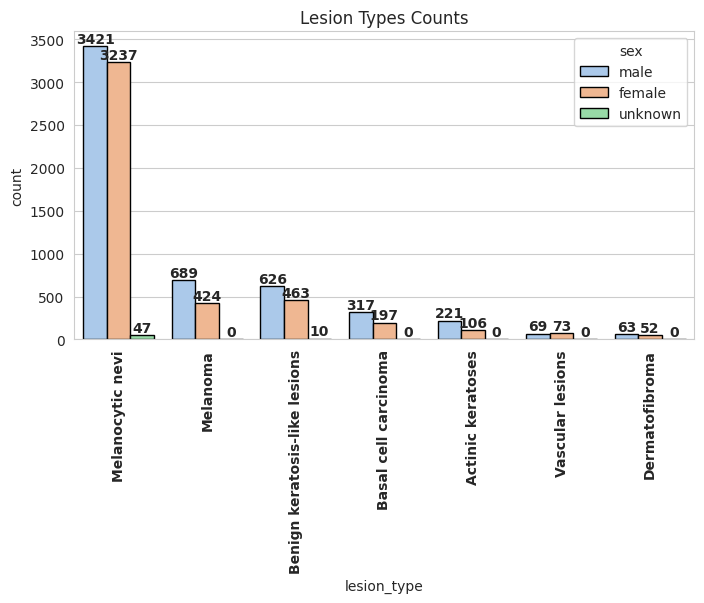

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting count plot after printing missing values
sns.set_style('whitegrid')
fig, axes = plt.subplots(figsize=(8, 4))
ax = sns.countplot(x='lesion_type', hue='sex', data=cancer_data, order=cancer_data['lesion_type'].value_counts().index, palette='pastel', edgecolor='black')
for container in ax.containers:
    ax.bar_label(container, weight='bold')
plt.title('Lesion Types Counts')
plt.xticks(rotation=90, weight='bold')
plt.show()


* It appears that across all types of skin cancer, a substantial majority of individuals affected are males.

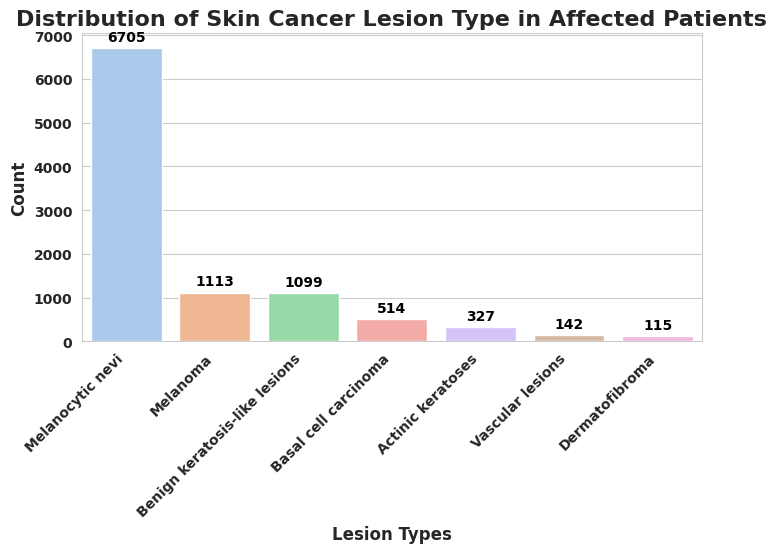

In [ ]:
sns.set_style('whitegrid')
fig, axes = plt.subplots(figsize=(8,4))
ax = sns.countplot(x='lesion_type', data=cancer_data, order=cancer_data['lesion_type'].value_counts().index, palette='pastel')
for container in ax.containers:
    ax.bar_label(container, fmt="%d", fontsize=10, color='black', label_type='edge', weight='bold', padding=3)

plt.title('Distribution of Skin Cancer Lesion Type in Affected Patients', fontsize=16, weight='bold')
plt.xlabel('Lesion Types', fontsize=12, weight='bold')
plt.ylabel('Count', fontsize=12, weight='bold')
plt.xticks(rotation=45, ha='right', fontsize=10, weight='bold')
plt.yticks(fontsize=10, weight='bold')

plt.show()

* Melanocytic nevi exhibit a significantly higher number of cases compared to other types.
* Melanoma and Benign keratosis-like lesions are less widespread in comparison to Melanocytic nevi.
* Other cell types show a subsequent lower incidence in terms of numbers.

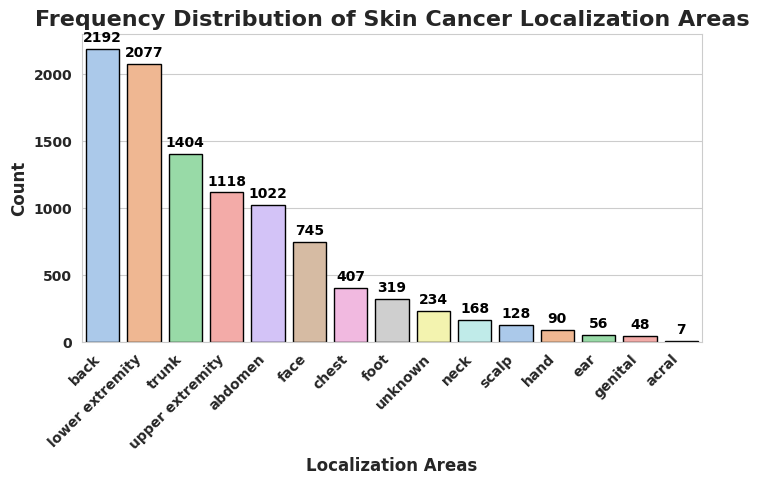

In [ ]:
sns.set_style('whitegrid')
fig, axes = plt.subplots(figsize=(8,4))
ax = sns.countplot(x='localization', data=cancer_data, order=cancer_data['localization'].value_counts().index, palette='pastel',  edgecolor='black')
for container in ax.containers:
    ax.bar_label(container, fmt="%d", fontsize=10, color='black', label_type='edge', weight='bold', padding=3)

plt.title('Frequency Distribution of Skin Cancer Localization Areas', fontsize=16, weight='bold')
plt.xlabel('Localization Areas', fontsize=12, weight='bold')
plt.ylabel('Count', fontsize=12, weight='bold')
plt.xticks(rotation=45, ha='right', fontsize=10, weight='bold')
plt.yticks(fontsize=10, weight='bold')

plt.show()

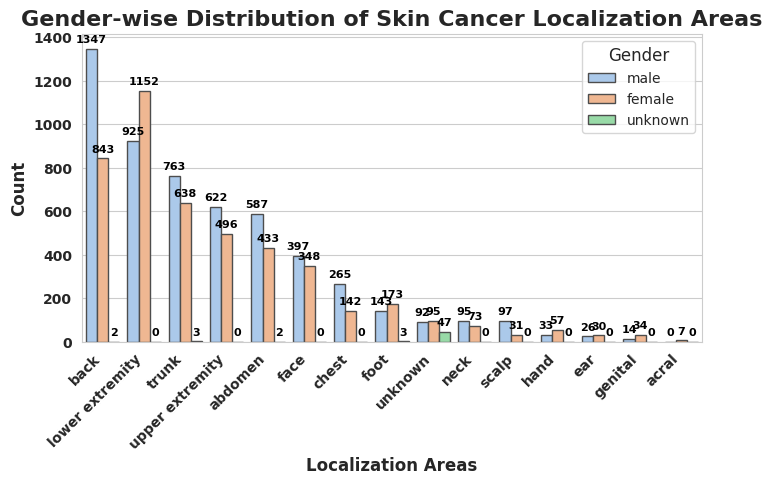

In [ ]:
sns.set_style('whitegrid')
fig, axes = plt.subplots(figsize=(8,4))
ax = sns.countplot(x='localization', hue='sex', data=cancer_data, order=cancer_data['localization'].value_counts().index, palette='pastel', edgecolor=".3")
for container in ax.containers:
    ax.bar_label(container, fmt="%d", fontsize=8, color='black', label_type='edge', weight='bold', padding=3)

plt.title('Gender-wise Distribution of Skin Cancer Localization Areas', fontsize=16, weight='bold')
plt.xlabel('Localization Areas', fontsize=12, weight='bold')
plt.ylabel('Count', fontsize=12, weight='bold')
plt.xticks(rotation=45, ha='right', fontsize=10, weight='bold')
plt.yticks(fontsize=10, weight='bold')
plt.legend(title='Gender', title_fontsize='12', fontsize='10')

plt.show()

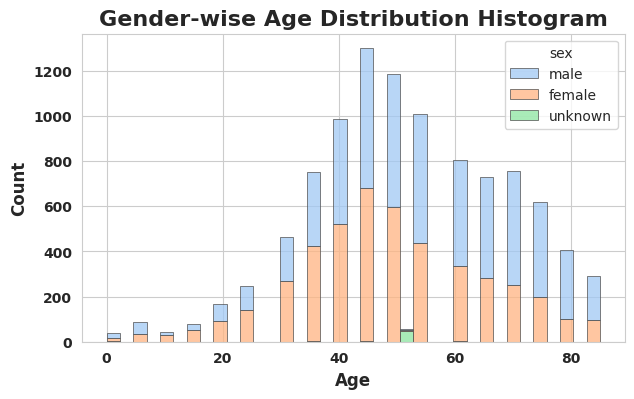

In [ ]:
sns.set_style('whitegrid')
fig, axes = plt.subplots(figsize=(7,4))
ax = sns.histplot(data=cancer_data, x='age', hue='sex', multiple='stack', palette='pastel', edgecolor=".3", linewidth=.5)

plt.title('Gender-wise Age Distribution Histogram', fontsize=16, weight='bold')
plt.xlabel('Age', fontsize=12, weight='bold')
plt.ylabel('Count', fontsize=12, weight='bold')
plt.xticks(fontsize=10, weight='bold')
plt.yticks(fontsize=10, weight='bold')

plt.show()

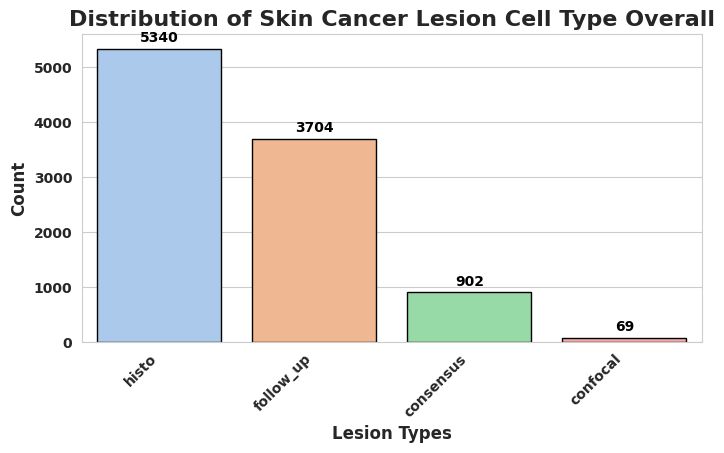

In [ ]:
sns.set_style('whitegrid')
fig, axes = plt.subplots(figsize=(8,4))
ax = sns.countplot(x='dx_type', data=cancer_data, order=cancer_data['dx_type'].value_counts().index, palette='pastel', edgecolor='black')
for container in ax.containers:
    ax.bar_label(container, fmt="%d", fontsize=10, color='black', label_type='edge', weight='bold', padding=3)

plt.title('Distribution of Skin Cancer Lesion Cell Type Overall', fontsize=16, weight='bold')
plt.xlabel('Lesion Types', fontsize=12, weight='bold')
plt.ylabel('Count', fontsize=12, weight='bold')
plt.xticks(rotation=45, ha='right', fontsize=10, weight='bold')
plt.yticks(fontsize=10, weight='bold')

plt.show()

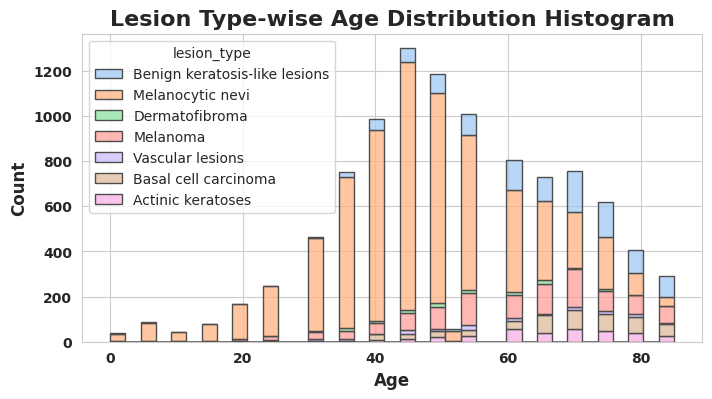

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style('whitegrid')
fig, axes = plt.subplots(figsize=(8, 4))
ax = sns.histplot(data=cancer_data, x='age',hue='lesion_type',multiple='stack', palette='pastel', edgecolor='.3')

plt.title('Lesion Type-wise Age Distribution Histogram', fontsize=16, weight='bold')
plt.xlabel('Age', fontsize=12, weight='bold')
plt.ylabel('Count', fontsize=12, weight='bold')
plt.xticks(fontsize=10, weight='bold')
plt.yticks(fontsize=10, weight='bold')
handles, labels = ax.get_legend_handles_labels()

plt.show()

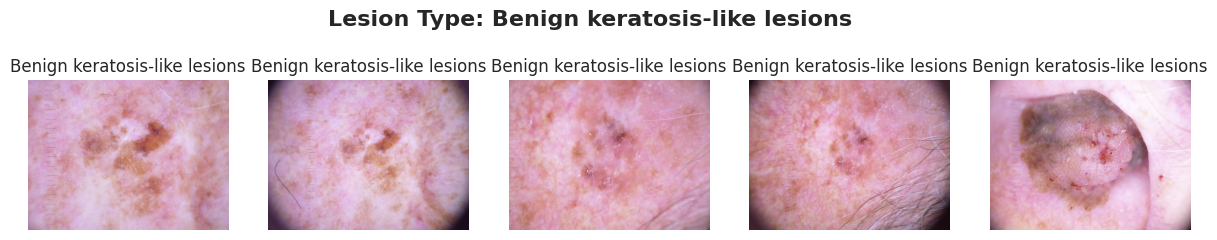

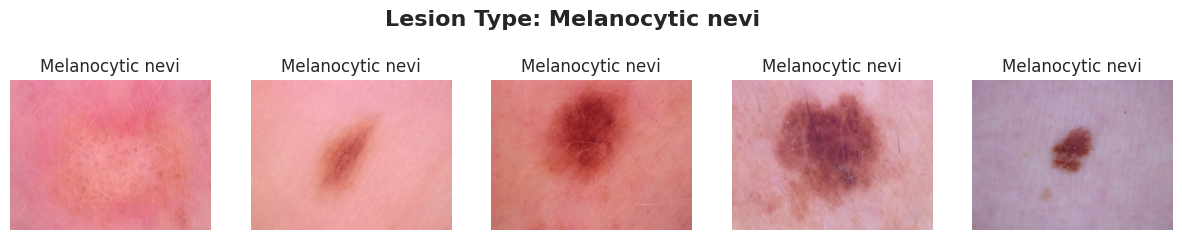

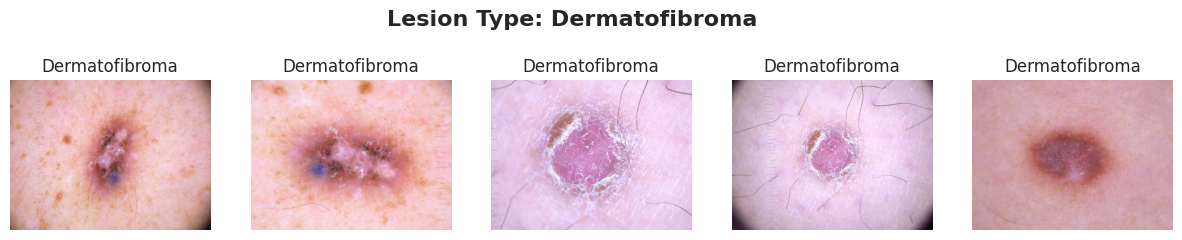

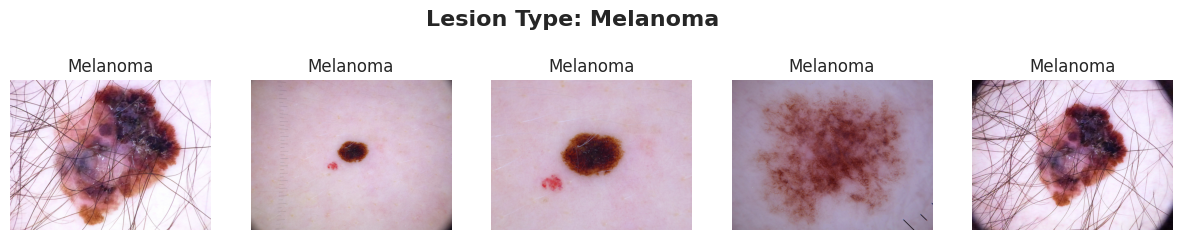

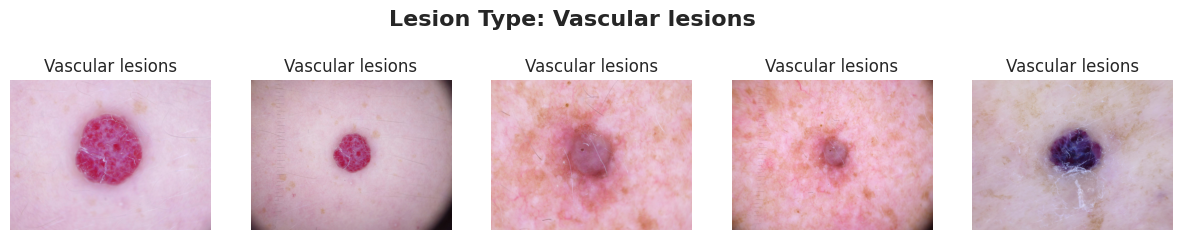

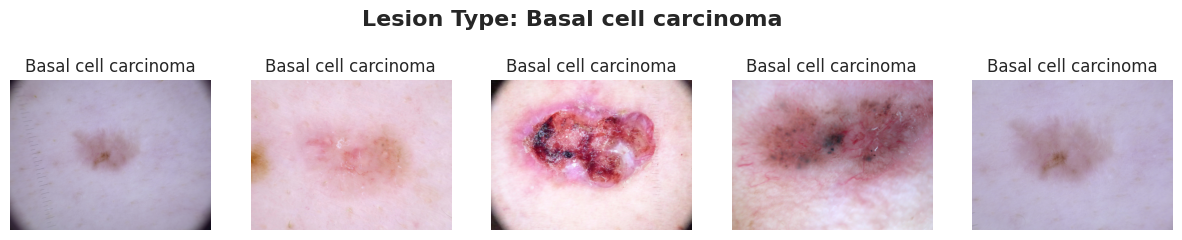

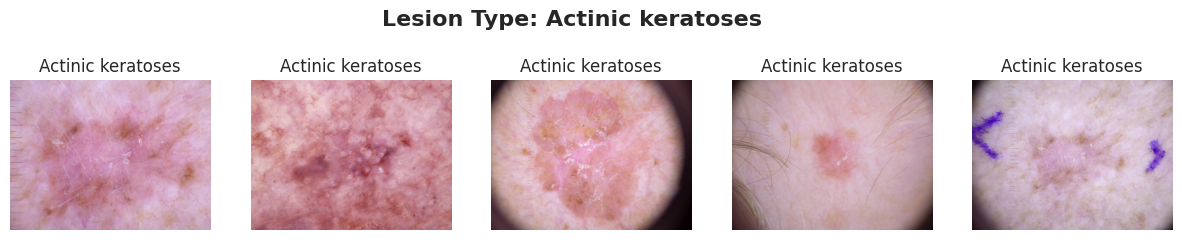

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Filter data for each lesion type
lesion_types = cancer_data['lesion_type'].unique()

# Plot 5 images for each lesion type
for lesion_type in lesion_types:
    subset = cancer_data[cancer_data['lesion_type'] == lesion_type].head(5)

    plt.figure(figsize=(15, 3))
    plt.suptitle(f'Lesion Type: {lesion_type}', fontsize=16, weight='bold')

    for index, row in subset.iterrows():
        img = mpimg.imread(row['img_path'])
        plt.subplot(1, 5, index % 5 + 1)
        plt.imshow(img)
        plt.title(row['lesion_type'])
        plt.axis('off')

    plt.show()

## **DATA PREPARATION AND PREPROCESSING**

In [ ]:
data = pd.read_csv(data_path)
data.head()

,pixel0000,pixel0001,pixel0002,pixel0003,pixel0004,pixel0005,pixel0006,pixel0007,pixel0008,pixel0009,...,pixel2343,pixel2344,pixel2345,pixel2346,pixel2347,pixel2348,pixel2349,pixel2350,pixel2351,label
0,192,153,193,195,155,192,197,154,185,202,...,173,124,138,183,147,166,185,154,177,2
1,25,14,30,68,48,75,123,93,126,158,...,60,39,55,25,14,28,25,14,27,2
2,192,138,153,200,145,163,201,142,160,206,...,167,129,143,159,124,142,136,104,117,2
3,38,19,30,95,59,72,143,103,119,171,...,44,26,36,25,12,17,25,12,15,2
4,158,113,139,194,144,174,215,162,191,225,...,209,166,185,172,135,149,109,78,92,2


**Split data and labels**

In [ ]:
Label = data["label"]
Data = data.drop(columns=["label"])

In [ ]:
data["label"].value_counts()

label
4    6705
6    1113
2    1099
1     514
0     327
5     142
3     115
Name: count, dtype: int64

We have imbalance data

### **IMBALANCE DATA HANDLING & AUGMENTATION**

* Data balancing using ADASYN technique
* Data Augmentation for variational data
    * rotation_range=20
    * width_shift_range=0.2
    * height_shift_range=0.2
    * horizontal_flip=True

In [ ]:
from imblearn.over_sampling import ADASYN
from keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import numpy as np


# Step 1: Apply ADASYN for synthetic oversampling
adasyn = ADASYN()
Data_adasyn, Label_adasyn = adasyn.fit_resample(Data, Label)
Data_adasyn = np.array(Data_adasyn).reshape(-1, 28, 28, 3)

# Step 2: Apply Data Augmentation on the oversampled data
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

augmented_data = []
for i in tqdm(range(len(Data_adasyn)), desc="Data Augmentation"):
    img = Data_adasyn[i]
    label = Label_adasyn[i]
    for j in range(5):  # Augment each image 5 times
        augmented_img = datagen.random_transform(img)
        augmented_data.append((augmented_img, label))


Data Augmentation: 100%|██████████| 47187/47187 [01:49<00:00, 429.07it/s]


### Data Preprocessing on Augmented Data

In [ ]:
Data_hybrid = []
Label_hybrid = []
for i in tqdm(range(len(augmented_data))):
    # Check the depth of the first image
    if augmented_data[i][0].dtype != np.uint8:
        # If the depth is not 8 bits per channel, convert it to 8 bits
        o = cv2.convertScaleAbs(augmented_data[i][0])
    image = o

    # Apply denoising (Non-Local Means Denoising)
    denoised_image = cv2.falabelstNlMeansDenoising(image, None, h=10, searchWindowSize=21)

    # Apply sharpening (Unsharp Masking)
    sharpening_filter = np.array([[-1, -1, -1],
                                  [-1, 9, -1],
                                  [-1, -1, -1]])
    sharpened_image = cv2.filter2D(denoised_image, -1, sharpening_filter)

    Data_hybrid.append(denoised_image)
    Label_hybrid.append(augmented_data[i][1])

In [ ]:
import pickle

# Saving the lists to a pickle file
with open('data_hybrid.pkl', 'wb') as f:
    pickle.dump(Data_hybrid, f)

with open('label_hybrid.pkl', 'wb') as f:
    pickle.dump(Label_hybrid, f)

In [ ]:
import pickle

# Load the pickled data
with open('/kaggle/input/augmented-data/data_hybrid.pkl', 'rb') as file:
    Data_hybrid = pickle.load(file)

with open('/kaggle/input/augmented-data/label_hybrid.pkl', 'rb') as file:
    Label_hybrid = pickle.load(file)


Data_hybrid = np.array(Data_hybrid)
Label_hybrid = np.array(Label_hybrid)

In [ ]:
Label_hybrid

array([2, 2, 2, ..., 6, 6, 6])

**Convert abbreviations to it's words**

In [ ]:
classes = {4: ('nv', ' melanocytic nevi'),
           6: ('mel', 'melanoma'),
           2 :('bkl', 'benign keratosis-like lesions'),
           1:('bcc' , ' basal cell carcinoma'),
           5: ('vasc', ' pyogenic granulomas and hemorrhage'),
           0: ('akiec', 'Actinic keratoses and intraepithelial carcinomae'),
           3: ('df', 'dermatofibroma')}

### **DATA SPLITTING**

In [ ]:
from sklearn.model_selection import train_test_split

X_train , X_test , y_train , y_test = train_test_split(Data_hybrid , Label_hybrid , test_size = 0.25 , random_state = 0, stratify = Label_hybrid)

In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(176951, 28, 28, 3)
(176951,)
(58984, 28, 28, 3)
(58984,)


**Convert labels to categorical types**

In [ ]:
from keras.utils import to_categorical

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

**Create Image Data Generation**

In [ ]:
datagen = ImageDataGenerator(rescale=(1./255)
                             ,rotation_range=10
                             ,zoom_range = 0.1
                             ,width_shift_range=0.1
                             ,height_shift_range=0.1)

testgen = ImageDataGenerator(rescale=(1./255))

**Create ReduceLROnPlateau to learning rate reduction**

In [ ]:
from keras.callbacks import ReduceLROnPlateau

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy'
                                            , patience = 2
                                            , verbose=1
                                            ,factor=0.5
                                            , min_lr=0.00001)

## **MODEL BUILDING & TRAINING**

### **MODEL 1: Custom CNN**

In [ ]:
model = keras.models.Sequential()

# Create Model Structure
model.add(keras.layers.Input(shape=[28, 28, 3]))
model.add(keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'))
model.add(keras.layers.MaxPooling2D())
model.add(keras.layers.BatchNormalization())

model.add(keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'))
model.add(keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'))
model.add(keras.layers.MaxPooling2D())
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'))
model.add(keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'))
model.add(keras.layers.MaxPooling2D())
model.add(keras.layers.BatchNormalization())

model.add(keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'))
model.add(keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'))
model.add(keras.layers.MaxPooling2D())

model.add(keras.layers.Flatten())
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.Dense(units=256, activation='relu', kernel_initializer='he_normal'))
model.add(keras.layers.BatchNormalization())

model.add(keras.layers.Dense(units=7, activation='softmax', kernel_initializer='glorot_uniform', name='classifier'))
model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 32)        0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 14, 14, 32)        128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 14, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 7, 7, 64)          0

**Training model**

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# Define the EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True)


# Use both callbacks in the training
history = model.fit(
    X_train,
    y_train,
    epochs=50,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping, learning_rate_reduction]
)

Epoch 1/50
1383/1383 [==============================] - 36s 13ms/step - loss: 0.8879 - accuracy: 0.6630 - val_loss: 0.7933 - val_accuracy: 0.6912 - lr: 0.0010
Epoch 2/50
1383/1383 [==============================] - 17s 12ms/step - loss: 0.5509 - accuracy: 0.7918 - val_loss: 0.4945 - val_accuracy: 0.8134 - lr: 0.0010
Epoch 3/50
1383/1383 [==============================] - 17s 12ms/step - loss: 0.4101 - accuracy: 0.8467 - val_loss: 0.4528 - val_accuracy: 0.8256 - lr: 0.0010
Epoch 4/50
1383/1383 [==============================] - 17s 12ms/step - loss: 0.3244 - accuracy: 0.8791 - val_loss: 0.3805 - val_accuracy: 0.8581 - lr: 0.0010
Epoch 5/50
1383/1383 [==============================] - 17s 12ms/step - loss: 0.2631 - accuracy: 0.9017 - val_loss: 0.2840 - val_accuracy: 0.8961 - lr: 0.0010
Epoch 6/50
1383/1383 [==============================] - 17s 13ms/step - loss: 0.2169 - accuracy: 0.9199 - val_loss: 0.2513 - val_accuracy: 0.9092 - lr: 0.0010
Epoch 7/50
1383/1383 [========================

In [ ]:
# predict
y_true = np.array(y_test)
y_pred = model.predict(X_test)

y_pred = np.argmax(y_pred , axis=1)
y_true = np.argmax(y_true , axis=1)

1844/1844 [==============================] - 5s 2ms/step


### Evaluation Utilities

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

def evaluate_model(y_test, y_pred, model_name):
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    print(f"{model_name} | Accuracy: {accuracy:.4f}")
    print(f"{model_name} | Precision: {precision:.4f}")
    print(f"{model_name} | F1-score: {f1:.4f}")
    print(f"{model_name} | Recall: {recall:.4f}")

    scores = {
    'accuracy': accuracy,
    'precision': precision,
    'f1': f1,
    'recall': recall}

    return scores

def plot_training(hist):
    tr_acc = hist.history['accuracy']
    tr_loss = hist.history['loss']
    val_acc = hist.history['val_accuracy']
    val_loss = hist.history['val_loss']
    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]
    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]

    plt.figure(figsize= (15, 6))
    plt.style.use('fivethirtyeight')
    Epochs = [i+1 for i in range(len(tr_acc))]
    loss_label = f'best epoch= {str(index_loss + 1)}'
    acc_label = f'best epoch= {str(index_acc + 1)}'

    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout
    plt.show()

In [ ]:
loss, acc = model.evaluate(X_test , y_test)
cnn_scores = evaluate_model(y_true, y_pred, 'CNN')
cnn_scores['loss'] = loss

print(f"CNN | loss: {loss:.4f}")

1844/1844 [==============================] - 8s 4ms/step - loss: 0.1775 - accuracy: 0.9438
CNN | Accuracy: 0.9438
CNN | Precision: 0.9444
CNN | F1-score: 0.9436
CNN | Recall: 0.9438
CNN | loss: 0.1775


**Show training history**

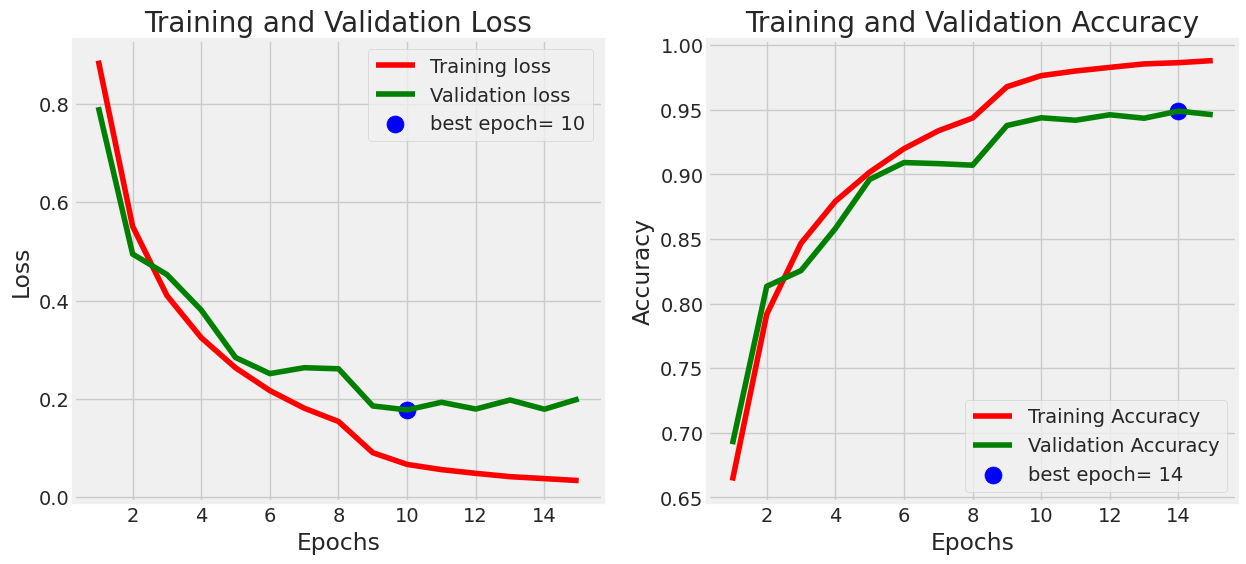

In [ ]:
plot_training(history)

**Save model**

In [ ]:
#Save the model
model.save('Skin Cancer Model(CNN).h5')

### **Model 2: CNN-LSTM (AdaMax Optimiser)**

In [ ]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, BatchNormalization, Flatten, Dense, LSTM, Reshape
from keras.optimizers import Adamax

# Input for the image data
image_input = Input(shape=[28, 28, 3])

# Convolutional block
def conv_block(x, filters, kernel_size=3, strides=1, use_batch_norm=True):
    x = Conv2D(filters, kernel_size, strides=strides, activation='relu', padding='same', kernel_initializer='he_normal')(x)
    if use_batch_norm:
        x = BatchNormalization()(x)
    return x

# CNN layers
cnn = conv_block(image_input, 32)
cnn = conv_block(cnn, 32)
cnn = MaxPooling2D()(cnn)
cnn = BatchNormalization()(cnn)

cnn = conv_block(cnn, 64)
cnn = conv_block(cnn, 64)
cnn = MaxPooling2D()(cnn)
cnn = BatchNormalization()(cnn)

cnn = conv_block(cnn, 128)
cnn = conv_block(cnn, 128)
cnn = MaxPooling2D()(cnn)
cnn = BatchNormalization()(cnn)

# Reshape for LSTM layer
cnn = Reshape((-1, 128))(cnn)

# LSTM layer
lstm = LSTM(64, return_sequences=True)(cnn)

# Flatten and dense layers
lstm = Flatten()(lstm)
lstm = Dense(units=256, activation='relu', kernel_initializer='he_normal')(lstm)
lstm = BatchNormalization()(lstm)


output = Dense(units=7, activation='softmax', kernel_initializer='glorot_uniform', name='classifier')(lstm)

# Create the model
model = Model(inputs=image_input, outputs=output)
model.compile(Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()


Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 28, 28, 3)]       0         
                                                                 
 conv2d_55 (Conv2D)          (None, 28, 28, 32)        896       
                                                                 
 batch_normalization_75 (Ba  (None, 28, 28, 32)        128       
 tchNormalization)                                               
                                                                 
 conv2d_56 (Conv2D)          (None, 28, 28, 32)        9248      
                                                                 
 batch_normalization_76 (Ba  (None, 28, 28, 32)        128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_17 (MaxPooli  (None, 14, 14, 32)        0   

In [ ]:
# Use both callbacks in the training
model2_history = model.fit(
    X_train,
    y_train,
    epochs=50,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping, learning_rate_reduction])

Epoch 1/50
1383/1383 [==============================] - 34s 18ms/step - loss: 0.7929 - accuracy: 0.7015 - val_loss: 0.6608 - val_accuracy: 0.7517 - lr: 0.0010
Epoch 2/50
1383/1383 [==============================] - 24s 17ms/step - loss: 0.4942 - accuracy: 0.8166 - val_loss: 0.4620 - val_accuracy: 0.8284 - lr: 0.0010
Epoch 3/50
1383/1383 [==============================] - 24s 17ms/step - loss: 0.3725 - accuracy: 0.8623 - val_loss: 0.4247 - val_accuracy: 0.8397 - lr: 0.0010
Epoch 4/50
1383/1383 [==============================] - 24s 17ms/step - loss: 0.2944 - accuracy: 0.8916 - val_loss: 0.4019 - val_accuracy: 0.8525 - lr: 0.0010
Epoch 5/50
1383/1383 [==============================] - 24s 17ms/step - loss: 0.2416 - accuracy: 0.9119 - val_loss: 0.4063 - val_accuracy: 0.8525 - lr: 0.0010
Epoch 6/50
1383/1383 [==============================] - 24s 17ms/step - loss: 0.2009 - accuracy: 0.9272 - val_loss: 0.2741 - val_accuracy: 0.9017 - lr: 0.0010
Epoch 7/50
1383/1383 [========================

In [ ]:
# predict
y_true = np.array(y_test)
y_pred = model.predict(X_test)

y_pred = np.argmax(y_pred , axis=1)
y_true = np.argmax(y_true , axis=1)

1844/1844 [==============================] - 7s 3ms/step


In [ ]:
loss, acc = model.evaluate(X_test , y_test)
cnn_lstm_scores = evaluate_model(y_true, y_pred, 'CNN-LSTM')
cnn_lstm_scores['loss'] = loss

print(f"CNN-LSTM | loss: {loss:.4f}")

1844/1844 [==============================] - 9s 5ms/step - loss: 0.1591 - accuracy: 0.9521
CNN-LSTM | Accuracy: 0.9521
CNN-LSTM | Precision: 0.9521
CNN-LSTM | F1-score: 0.9519
CNN-LSTM | Recall: 0.9521
CNN-LSTM | loss: 0.1591


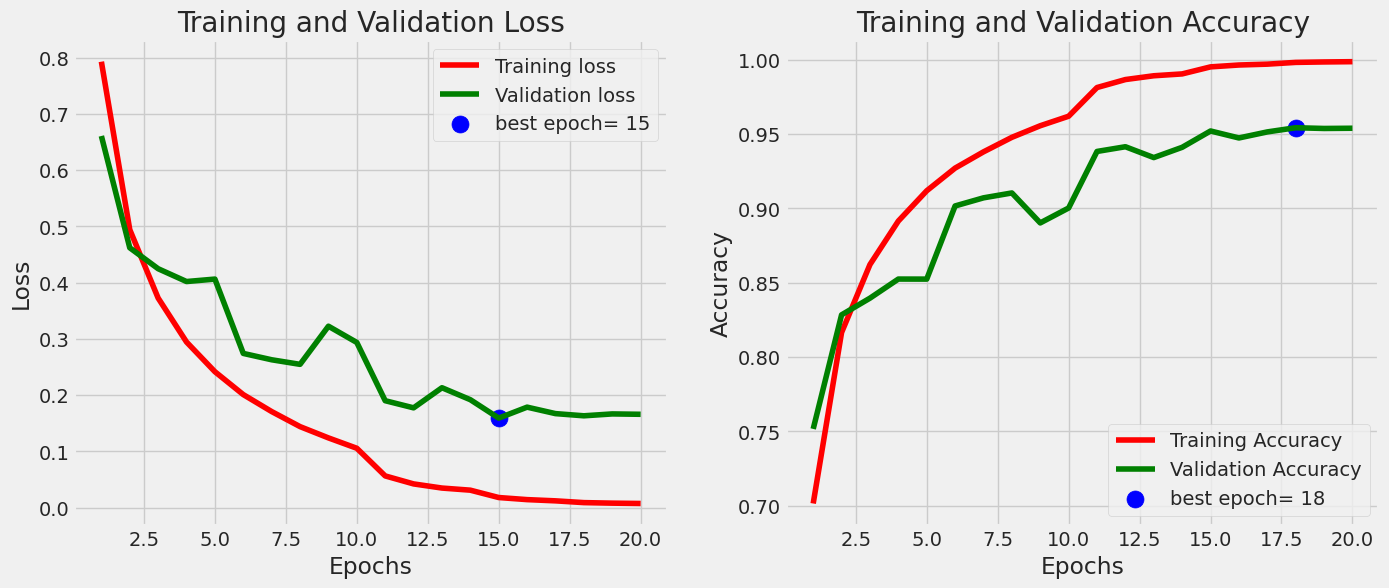

In [ ]:
plot_training(model2_history)

In [ ]:
#Save the model
model.save('Skin Cancer model (CNN-LSTM).h5')

### **MODEL 3: Residual Attention Based CNN: Residual ShieldNet**

In [ ]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, BatchNormalization, Flatten, Dense, Dropout, Add, Attention
from keras.optimizers import Adamax

# Input for the image data
image_input = Input(shape=[28, 28, 3])

# Convolutional block
def conv_block(x, filters, kernel_size=3, strides=1, use_batch_norm=True):
    x = Conv2D(filters, kernel_size, strides=strides, activation='relu', padding='same', kernel_initializer='he_normal')(x)
    if use_batch_norm:
        x = BatchNormalization()(x)
    return x

# Residual block
def residual_block(x, filters):
    shortcut = x
    x = conv_block(x, filters)
    x = conv_block(x, filters, use_batch_norm=False)
    x = Add()([x, shortcut])
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

# Attention block
def attention_block(x):
    g = Conv2D(int(x.shape[-1]), kernel_size=1, strides=1, use_bias=False)(x)
    g = BatchNormalization()(g)
    x = Attention()([g, x])
    return x

# CNN layers
cnn = conv_block(image_input, 128)
cnn = conv_block(cnn, 128)
cnn = MaxPooling2D()(cnn)
cnn = BatchNormalization()(cnn)

cnn = residual_block(cnn, 128)
cnn = residual_block(cnn, 128)
cnn = MaxPooling2D()(cnn)
cnn = BatchNormalization()(cnn)


# Attention mechanism
cnn = attention_block(cnn)

# Flatten and dense layers
cnn = Flatten()(cnn)
cnn = Dropout(rate=0.2)(cnn)
cnn = Dense(units=256, activation='relu', kernel_initializer='he_normal')(cnn)
cnn = BatchNormalization()(cnn)


output = Dense(units=7, activation='softmax', kernel_initializer='glorot_uniform', name='classifier')(cnn)

# Create the model
model = Model(inputs=image_input, outputs=output)
model.compile(Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()


Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 28, 28, 3)]          0         []                            
                                                                                                  
 conv2d_48 (Conv2D)          (None, 28, 28, 128)          3584      ['input_7[0][0]']             
                                                                                                  
 batch_normalization_65 (Ba  (None, 28, 28, 128)          512       ['conv2d_48[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 conv2d_49 (Conv2D)          (None, 28, 28, 128)          147584    ['batch_normalization_65

In [ ]:
# Use both callbacks in the training
model3_history = model.fit(
    X_train,
    y_train,
    epochs=50,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping, learning_rate_reduction])

Epoch 1/50
1383/1383 [==============================] - 74s 49ms/step - loss: 0.8879 - accuracy: 0.6683 - val_loss: 0.6915 - val_accuracy: 0.7386 - lr: 0.0010
Epoch 2/50
1383/1383 [==============================] - 66s 48ms/step - loss: 0.6116 - accuracy: 0.7703 - val_loss: 0.5520 - val_accuracy: 0.7919 - lr: 0.0010
Epoch 3/50
1383/1383 [==============================] - 66s 48ms/step - loss: 0.4828 - accuracy: 0.8187 - val_loss: 0.4440 - val_accuracy: 0.8331 - lr: 0.0010
Epoch 4/50
1383/1383 [==============================] - 67s 48ms/step - loss: 0.3789 - accuracy: 0.8599 - val_loss: 0.3554 - val_accuracy: 0.8702 - lr: 0.0010
Epoch 5/50
1383/1383 [==============================] - 66s 48ms/step - loss: 0.3064 - accuracy: 0.8863 - val_loss: 0.3186 - val_accuracy: 0.8830 - lr: 0.0010
Epoch 6/50
1383/1383 [==============================] - 66s 48ms/step - loss: 0.2547 - accuracy: 0.9070 - val_loss: 0.3155 - val_accuracy: 0.8857 - lr: 0.0010
Epoch 7/50
1383/1383 [========================

In [ ]:
# predict
y_true = np.array(y_test)
y_pred = model.predict(X_test)

y_pred = np.argmax(y_pred , axis=1)
y_true = np.argmax(y_true , axis=1)

1844/1844 [==============================] - 8s 4ms/step


In [ ]:
loss, acc = model.evaluate(X_test , y_test)
residual_shieldnet_scores = evaluate_model(y_true, y_pred, 'Residual ShieldNet')
residual_shieldnet_scores['loss'] = loss

print(f"Residual ShieldNet | loss: {loss:.4f}")

Residual ShieldNet | Accuracy: 0.9653
Residual ShieldNet | Precision: 0.9654
Residual ShieldNet | F1-score: 0.9651
Residual ShieldNet | Recall: 0.9653
Residual ShieldNet | loss: 0.1040


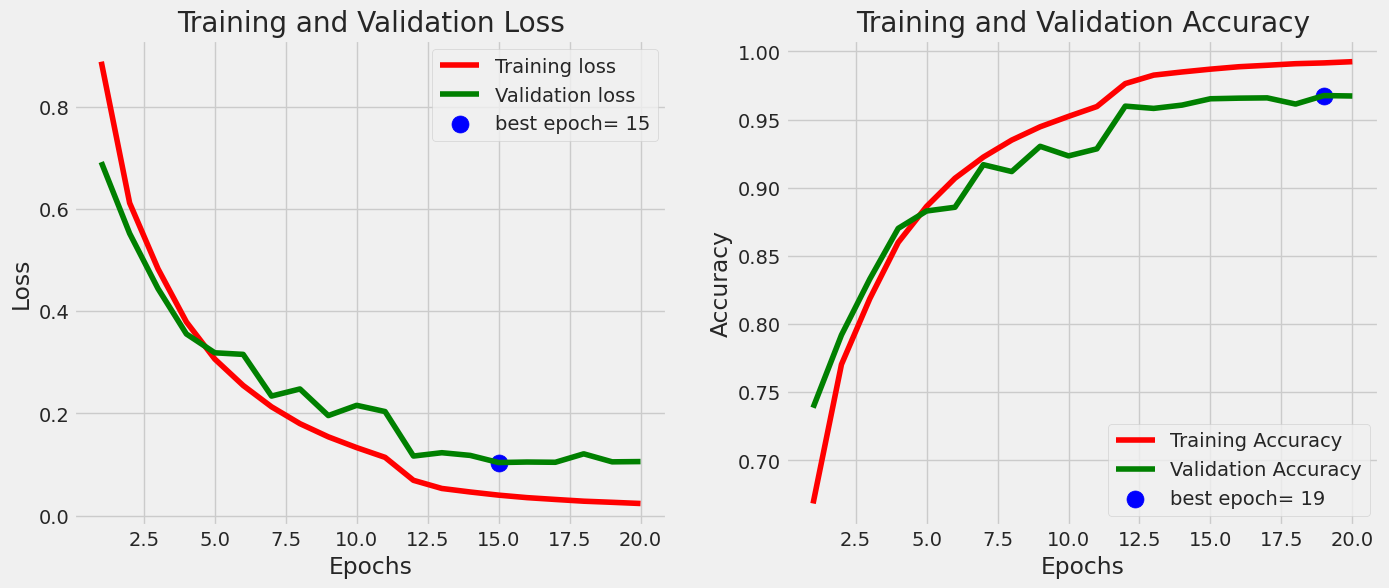

In [ ]:
plot_training(model3_history)

In [ ]:
#Save the model
model.save('Skin Cancer model (Residual ShieldNet).h5')

### **Performance Scores**

In [ ]:
cnn_lstm_scores

{'accuracy': 0.9521395632713956,
 'precision': 0.9521217338098806,
 'f1': 0.9519431993505671,
 'recall': 0.9521395632713956,
 'loss': 0.15910068154335022}

In [ ]:
cnn_scores

{'accuracy': 0.9438152719381527,
 'precision': 0.9444293312124584,
 'f1': 0.9436203206429892,
 'recall': 0.9438152719381527,
 'loss': 0.17752684652805328}

In [ ]:
residual_shieldnet_scores

{'accuracy': 0.9652956734029567,
 'precision': 0.9654357472513039,
 'f1': 0.9651410918211796,
 'recall': 0.9652956734029567,
 'loss': 0.104}

In [ ]:
diagnosis_model_results = pd.DataFrame({'Custom CNN': cnn_scores,
              'CNN-LSTM': cnn_lstm_scores,
              'Residual ShiledNet': residual_shieldnet_scores
             }).T

diagnosis_model_results

,accuracy,precision,f1,recall,loss
Custom CNN,0.943815,0.944429,0.943620,0.943815,0.177527
CNN-LSTM,0.952140,0.952122,0.951943,0.952140,0.159101
Residual ShiledNet,0.965296,0.965436,0.965141,0.965296,0.104000
